# Hudba a neurónové siete
## Bakárska práca
### Peter Oliver Kolek

In [1]:
from mido import MidiFile, MidiTrack, MetaMessage, bpm2tempo, Message
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras
from scipy.stats import gmean
import time

In [2]:
def get_list_of_content(file_name):
    f = open(file_name, "r")
    return f.read().splitlines()

In [3]:
def open_midi(midi_file):
    # open midi file
    mid = MidiFile(midi_file, clip=True)

    drum_track_number = 0
    # find track number of drums
    for i in range(len(mid.tracks)):
        for j in range(len(mid.tracks[i])):
            if mid.tracks[i][j].is_meta:
                continue
            if mid.tracks[i][j].channel == 9:
                drum_track_number = i
                break
    print("Drum track number: ", str(drum_track_number))
    return mid, mid.tracks[drum_track_number]

In [4]:
def get_transcription(drum_track, mid):
    # find ticks per beat, and divide it to Thirty-Second 32 notes
    ticks_per_beat_in_32_notes = mid.ticks_per_beat / 8
#     print(ticks_per_beat_in_32_notes)
    # change notes time to stick it to 32 notes
    tmp_time = 0
    time_with_note = {}
    for i, message in enumerate(drum_track):
        # find time how it goes through song
        tmp_time += drum_track[i].time
        message.time = round(tmp_time / ticks_per_beat_in_32_notes)
#         print("i: ", i, "msg time: ", message.time, "tmp time: ", tmp_time, "Msg_type: ", message.type)
        # make velocity of notes same
        if message.type == 'note_on':
            if message.velocity > 0:
                message.velocity = 1

    # crating DataFrame for notes sticked to 32s and filter only note_on notes
    transcription = pd.DataFrame(m.dict() for m in drum_track)
    transcription = transcription[transcription.type == 'note_on']
    # modify table to have columns for every note and lines with time (32 notes as they folow the song)
    transcription = transcription.pivot_table(index='time', columns='note', values='velocity', fill_value=0)
    # because we have 4/4 tempo, we have to add notes to have folowing 32 notes and empty values we fill with zeros
    transcription = transcription.reindex(pd.RangeIndex(transcription.index.max() + 1)).fillna(0).sort_index()
    # retype to int
    transcription = transcription.astype(int)
    transcription.columns = transcription.columns.astype(int)
    transcription = transcription.reset_index(drop=True)
    return transcription

In [5]:
def create_midi(tempo, transcription, ticks_per_beat, file_name, instruments):
    # create new midi file
    new_mid = MidiFile()
    new_mid.ticks_per_beat = ticks_per_beat
    meta_track = MidiTrack()
    new_mid.tracks.append(meta_track)

    # necessary meta track
    meta_track.append(MetaMessage(type='track_name', name='meta_track', time=0))
    meta_track.append(MetaMessage(type='time_signature', numerator=4, denominator=4, clocks_per_click=24,
                                  notated_32nd_notes_per_beat=8, time=0))
    meta_track.append(MetaMessage(type='set_tempo', tempo=bpm2tempo(tempo), time=0))

    drum_track_new = MidiTrack()
    new_mid.tracks.append(drum_track_new)

    # apend notes to drum track

    ticks_per_32note = int(ticks_per_beat/8)
    notes_from_last_message = 0
    for i, note in enumerate(transcription):
        if i == 0:
            for idx, inst in enumerate(note):
                if inst == 0:
                    continue
                drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
            continue
        else:
            if sum(note) < 1:
                notes_from_last_message += 1
                continue
            else:
                notes_from_last_message += 1

            same_note_count = 0
            for idx, inst in enumerate(note):
                if inst == 0:
                    pass
                # if there are more notes at the same time played, they must have time 0
                elif same_note_count == 0:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80,
                                                  time=notes_from_last_message * ticks_per_32note))
                    same_note_count += 1
                else:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
                    same_note_count += 1
            notes_from_last_message = 0
#     print(new_mid)
    new_mid.save(file_name)

In [6]:
start = time.time()

In [7]:
slipknot_list = get_list_of_content('./Slipknot_midi/list.txt')
print(slipknot_list)

['BeforeIForget.midi', 'Eyeless.midi', 'TheNameless.midi', 'Disasterpiece.midi', 'People=Shit.midi', 'WaitAndBleed.midi', 'Duality.midi', 'Sic.midi', 'Eeyore.midi', 'Surfacing.midi']


In [8]:
slipknot_transcription_full = pd.DataFrame()
frames = []
for item in slipknot_list:
    mid, drum_track = open_midi('./Slipknot_midi/' + item)
    transcription = get_transcription(drum_track, mid)
    frames.append(transcription)
    instruments = transcription.columns.tolist()


instruments = slipknot_transcription_full.columns.tolist()
slipknot_transcription_full = pd.concat(frames)
slipknot_transcription_full = slipknot_transcription_full.fillna(0)
slipknot_transcription_full = slipknot_transcription_full.astype(int)
slipknot_transcription_full = slipknot_transcription_full.reset_index(drop=True)

instruments = slipknot_transcription_full.columns.tolist()

create_midi(120, slipknot_transcription_full.values, mid.ticks_per_beat, "./output/transcription_full_slipknot.mid", instruments)

print(slipknot_transcription_full)

Drum track number:  7
Drum track number:  3
Drum track number:  5
Drum track number:  3
Drum track number:  6
Drum track number:  1
Drum track number:  4
Drum track number:  4
Drum track number:  5
Drum track number:  6
note   35  38  40  41  43  45  46  47  49  57  ...  37  42  44  48  51  55  \
0       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
1       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
2       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
4       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
45218   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
45219   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
45220   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   


In [9]:
train_test_split = int(slipknot_transcription_full.shape[0]*0.7)
train_test_split

31656

In [10]:
train = slipknot_transcription_full.loc[:train_test_split]
test = slipknot_transcription_full.loc[train_test_split:]

In [11]:
inputs_list = []
outputs_list = []
sequence_len = 32
raw_notes = train.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    inputs_list.append(raw_notes[input_start:input_end])
    outputs_list.append(raw_notes[output_start:output_end])

outputs_list = list(np.array(outputs_list).reshape(-1, np.array(outputs_list).shape[-1]))

inputs_list = np.array(inputs_list)
outputs_list = np.array(outputs_list)

output_shape = outputs_list.shape[1]

test_list = []
test_out = []
raw_notes = test.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    test_list.append(raw_notes[input_start:input_end])
    test_out.append(raw_notes[output_start:output_end])

test_out = list(np.array(test_out).reshape(-1, np.array(test_out).shape[-1]))

test_list = np.array(test_list)
test_out = np.array(test_out)

In [12]:
dropout = 0.2

# very very very basic LSTM model
model = Sequential()
model.add(LSTM(sequence_len, input_shape=(sequence_len, len(instruments)), return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, dropout=dropout))
model.add(Dense(output_shape, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.BinaryCrossentropy()])
model.summary()
mc = ModelCheckpoint(filepath='./new_encode_1st_try.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(inputs_list, outputs_list, epochs=300, callbacks=mc, validation_split=0.1, verbose=1, shuffle=False)

2022-04-04 21:03:25.595269: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 32)            7040      
                                                                 
 lstm_1 (LSTM)               (None, 32, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 22)                726       
                                                                 
Total params: 24,406
Trainable params: 24,406
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
889/890 [============================>.] - ETA: 0s - loss: 0.0966 - accuracy: 0.2168 - binary_crossentropy: 0.0966
Epoch 1: val_loss improved from inf to 0.07208, saving mo

Epoch 20/300
890/890 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.2841 - binary_crossentropy: 0.0579
Epoch 20: val_loss improved from 0.06158 to 0.06111, saving model to ./new_encode_1st_try.h5
890/890 [==============================] - 34s 38ms/step - loss: 0.0579 - accuracy: 0.2841 - binary_crossentropy: 0.0579 - val_loss: 0.0611 - val_accuracy: 0.0746 - val_binary_crossentropy: 0.0611
Epoch 21/300
890/890 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.3516 - binary_crossentropy: 0.0584
Epoch 21: val_loss improved from 0.06111 to 0.06096, saving model to ./new_encode_1st_try.h5
890/890 [==============================] - 34s 39ms/step - loss: 0.0584 - accuracy: 0.3516 - binary_crossentropy: 0.0584 - val_loss: 0.0610 - val_accuracy: 0.0746 - val_binary_crossentropy: 0.0610
Epoch 22/300
890/890 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.3429 - binary_crossentropy: 0.0587
Epoch 22: val_loss did not improve f

Epoch 41/300
889/890 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.2407 - binary_crossentropy: 0.0473
Epoch 41: val_loss improved from 0.05587 to 0.05527, saving model to ./new_encode_1st_try.h5
890/890 [==============================] - 35s 39ms/step - loss: 0.0473 - accuracy: 0.2406 - binary_crossentropy: 0.0473 - val_loss: 0.0553 - val_accuracy: 0.0980 - val_binary_crossentropy: 0.0553
Epoch 42/300
889/890 [============================>.] - ETA: 0s - loss: 0.0462 - accuracy: 0.2163 - binary_crossentropy: 0.0462
Epoch 42: val_loss did not improve from 0.05527
890/890 [==============================] - 36s 40ms/step - loss: 0.0462 - accuracy: 0.2163 - binary_crossentropy: 0.0462 - val_loss: 0.0556 - val_accuracy: 0.1043 - val_binary_crossentropy: 0.0556
Epoch 43/300
890/890 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.2183 - binary_crossentropy: 0.0454
Epoch 43: val_loss did not improve from 0.05527
890/890 [========================

Epoch 63/300
890/890 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.2130 - binary_crossentropy: 0.0413
Epoch 63: val_loss did not improve from 0.05527
890/890 [==============================] - 33s 37ms/step - loss: 0.0413 - accuracy: 0.2130 - binary_crossentropy: 0.0413 - val_loss: 0.0574 - val_accuracy: 0.0809 - val_binary_crossentropy: 0.0574
Epoch 64/300
889/890 [============================>.] - ETA: 0s - loss: 0.0407 - accuracy: 0.2565 - binary_crossentropy: 0.0407
Epoch 64: val_loss did not improve from 0.05527
890/890 [==============================] - 33s 37ms/step - loss: 0.0407 - accuracy: 0.2564 - binary_crossentropy: 0.0407 - val_loss: 0.0556 - val_accuracy: 0.0771 - val_binary_crossentropy: 0.0556
Epoch 65/300
890/890 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.2188 - binary_crossentropy: 0.0412
Epoch 65: val_loss did not improve from 0.05527
890/890 [==============================] - 33s 37ms/step - loss: 0.0412 - accu

Epoch 85/300
890/890 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.2440 - binary_crossentropy: 0.0325
Epoch 85: val_loss did not improve from 0.05421
890/890 [==============================] - 34s 39ms/step - loss: 0.0325 - accuracy: 0.2440 - binary_crossentropy: 0.0325 - val_loss: 0.0579 - val_accuracy: 0.1897 - val_binary_crossentropy: 0.0579
Epoch 86/300
889/890 [============================>.] - ETA: 0s - loss: 0.0323 - accuracy: 0.2444 - binary_crossentropy: 0.0323
Epoch 86: val_loss did not improve from 0.05421
890/890 [==============================] - 34s 38ms/step - loss: 0.0323 - accuracy: 0.2444 - binary_crossentropy: 0.0323 - val_loss: 0.0586 - val_accuracy: 0.1805 - val_binary_crossentropy: 0.0586
Epoch 87/300
889/890 [============================>.] - ETA: 0s - loss: 0.0319 - accuracy: 0.2513 - binary_crossentropy: 0.0319
Epoch 87: val_loss did not improve from 0.05421
890/890 [==============================] - 34s 38ms/step - loss: 0.0319 - accu

Epoch 107/300
889/890 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.2972 - binary_crossentropy: 0.0272
Epoch 107: val_loss improved from 0.05300 to 0.05205, saving model to ./new_encode_1st_try.h5
890/890 [==============================] - 34s 38ms/step - loss: 0.0272 - accuracy: 0.2972 - binary_crossentropy: 0.0272 - val_loss: 0.0521 - val_accuracy: 0.1113 - val_binary_crossentropy: 0.0521
Epoch 108/300
890/890 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.2725 - binary_crossentropy: 0.0272
Epoch 108: val_loss did not improve from 0.05205
890/890 [==============================] - 33s 37ms/step - loss: 0.0272 - accuracy: 0.2725 - binary_crossentropy: 0.0272 - val_loss: 0.0527 - val_accuracy: 0.1116 - val_binary_crossentropy: 0.0527
Epoch 109/300
890/890 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.2705 - binary_crossentropy: 0.0273
Epoch 109: val_loss improved from 0.05205 to 0.05140, saving model to ./new_

Epoch 129/300
890/890 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.2764 - binary_crossentropy: 0.0245
Epoch 129: val_loss did not improve from 0.05091
890/890 [==============================] - 33s 37ms/step - loss: 0.0245 - accuracy: 0.2764 - binary_crossentropy: 0.0245 - val_loss: 0.0524 - val_accuracy: 0.2071 - val_binary_crossentropy: 0.0524
Epoch 130/300
890/890 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.2940 - binary_crossentropy: 0.0250
Epoch 130: val_loss did not improve from 0.05091
890/890 [==============================] - 34s 38ms/step - loss: 0.0250 - accuracy: 0.2940 - binary_crossentropy: 0.0250 - val_loss: 0.0514 - val_accuracy: 0.1211 - val_binary_crossentropy: 0.0514
Epoch 131/300
890/890 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.2711 - binary_crossentropy: 0.0244
Epoch 131: val_loss did not improve from 0.05091
890/890 [==============================] - 33s 38ms/step - loss: 0.0244 

889/890 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.2865 - binary_crossentropy: 0.0231
Epoch 150: val_loss did not improve from 0.04656
890/890 [==============================] - 34s 38ms/step - loss: 0.0231 - accuracy: 0.2865 - binary_crossentropy: 0.0231 - val_loss: 0.0482 - val_accuracy: 0.2232 - val_binary_crossentropy: 0.0482
Epoch 151/300
889/890 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.2949 - binary_crossentropy: 0.0228
Epoch 151: val_loss did not improve from 0.04656
890/890 [==============================] - 34s 38ms/step - loss: 0.0228 - accuracy: 0.2948 - binary_crossentropy: 0.0228 - val_loss: 0.0481 - val_accuracy: 0.1426 - val_binary_crossentropy: 0.0481
Epoch 152/300
889/890 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.2861 - binary_crossentropy: 0.0228
Epoch 152: val_loss did not improve from 0.04656
890/890 [==============================] - 34s 38ms/step - loss: 0.0228 - accuracy: 0.

Epoch 172/300
890/890 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.3184 - binary_crossentropy: 0.0217
Epoch 172: val_loss did not improve from 0.04656
890/890 [==============================] - 35s 39ms/step - loss: 0.0217 - accuracy: 0.3184 - binary_crossentropy: 0.0217 - val_loss: 0.0480 - val_accuracy: 0.2365 - val_binary_crossentropy: 0.0480
Epoch 173/300
890/890 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.2974 - binary_crossentropy: 0.0213
Epoch 173: val_loss did not improve from 0.04656
890/890 [==============================] - 34s 38ms/step - loss: 0.0213 - accuracy: 0.2974 - binary_crossentropy: 0.0213 - val_loss: 0.0481 - val_accuracy: 0.1451 - val_binary_crossentropy: 0.0481
Epoch 174/300
889/890 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.2933 - binary_crossentropy: 0.0215
Epoch 174: val_loss did not improve from 0.04656
890/890 [==============================] - 34s 38ms/step - loss: 0.0215 

Epoch 194/300
890/890 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.3012 - binary_crossentropy: 0.0210
Epoch 194: val_loss did not improve from 0.04656
890/890 [==============================] - 32s 36ms/step - loss: 0.0210 - accuracy: 0.3012 - binary_crossentropy: 0.0210 - val_loss: 0.0500 - val_accuracy: 0.2200 - val_binary_crossentropy: 0.0500
Epoch 195/300
890/890 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.2917 - binary_crossentropy: 0.0207
Epoch 195: val_loss did not improve from 0.04656
890/890 [==============================] - 32s 36ms/step - loss: 0.0207 - accuracy: 0.2917 - binary_crossentropy: 0.0207 - val_loss: 0.0494 - val_accuracy: 0.1296 - val_binary_crossentropy: 0.0494
Epoch 196/300
889/890 [============================>.] - ETA: 0s - loss: 0.0207 - accuracy: 0.3064 - binary_crossentropy: 0.0207
Epoch 196: val_loss did not improve from 0.04656
890/890 [==============================] - 32s 36ms/step - loss: 0.0207 

Epoch 216/300
890/890 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.3076 - binary_crossentropy: 0.0195
Epoch 216: val_loss did not improve from 0.04656
890/890 [==============================] - 32s 36ms/step - loss: 0.0195 - accuracy: 0.3076 - binary_crossentropy: 0.0195 - val_loss: 0.0481 - val_accuracy: 0.1432 - val_binary_crossentropy: 0.0481
Epoch 217/300
890/890 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.3128 - binary_crossentropy: 0.0196
Epoch 217: val_loss did not improve from 0.04656
890/890 [==============================] - 32s 36ms/step - loss: 0.0196 - accuracy: 0.3128 - binary_crossentropy: 0.0196 - val_loss: 0.0491 - val_accuracy: 0.2242 - val_binary_crossentropy: 0.0491
Epoch 218/300
889/890 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.3041 - binary_crossentropy: 0.0197
Epoch 218: val_loss did not improve from 0.04656
890/890 [==============================] - 32s 36ms/step - loss: 0.0197 

Epoch 238/300
889/890 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.3342 - binary_crossentropy: 0.0199
Epoch 238: val_loss did not improve from 0.04656
890/890 [==============================] - 32s 36ms/step - loss: 0.0199 - accuracy: 0.3341 - binary_crossentropy: 0.0199 - val_loss: 0.0497 - val_accuracy: 0.2314 - val_binary_crossentropy: 0.0497
Epoch 239/300
889/890 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.3339 - binary_crossentropy: 0.0196
Epoch 239: val_loss did not improve from 0.04656
890/890 [==============================] - 33s 37ms/step - loss: 0.0196 - accuracy: 0.3338 - binary_crossentropy: 0.0196 - val_loss: 0.0495 - val_accuracy: 0.2242 - val_binary_crossentropy: 0.0495
Epoch 240/300
889/890 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.3047 - binary_crossentropy: 0.0194
Epoch 240: val_loss did not improve from 0.04656
890/890 [==============================] - 33s 37ms/step - loss: 0.0194 

Epoch 260/300
888/890 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.3083 - binary_crossentropy: 0.0189
Epoch 260: val_loss did not improve from 0.04656
890/890 [==============================] - 19s 22ms/step - loss: 0.0189 - accuracy: 0.3082 - binary_crossentropy: 0.0189 - val_loss: 0.0493 - val_accuracy: 0.2276 - val_binary_crossentropy: 0.0493
Epoch 261/300
889/890 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.3272 - binary_crossentropy: 0.0186
Epoch 261: val_loss did not improve from 0.04656
890/890 [==============================] - 19s 22ms/step - loss: 0.0186 - accuracy: 0.3272 - binary_crossentropy: 0.0186 - val_loss: 0.0496 - val_accuracy: 0.2321 - val_binary_crossentropy: 0.0496
Epoch 262/300
890/890 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.2909 - binary_crossentropy: 0.0191
Epoch 262: val_loss did not improve from 0.04656
890/890 [==============================] - 19s 22ms/step - loss: 0.0191 

Epoch 282/300
888/890 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.3032 - binary_crossentropy: 0.0183
Epoch 282: val_loss did not improve from 0.04656
890/890 [==============================] - 20s 22ms/step - loss: 0.0183 - accuracy: 0.3032 - binary_crossentropy: 0.0183 - val_loss: 0.0499 - val_accuracy: 0.2261 - val_binary_crossentropy: 0.0499
Epoch 283/300
889/890 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.2967 - binary_crossentropy: 0.0181
Epoch 283: val_loss did not improve from 0.04656
890/890 [==============================] - 19s 22ms/step - loss: 0.0181 - accuracy: 0.2967 - binary_crossentropy: 0.0181 - val_loss: 0.0499 - val_accuracy: 0.2346 - val_binary_crossentropy: 0.0499
Epoch 284/300
888/890 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.3001 - binary_crossentropy: 0.0185
Epoch 284: val_loss did not improve from 0.04656
890/890 [==============================] - 20s 22ms/step - loss: 0.0185 

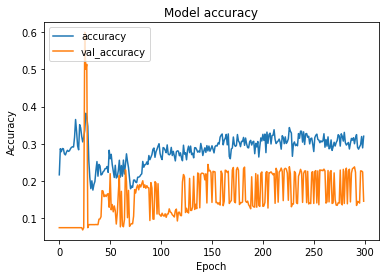

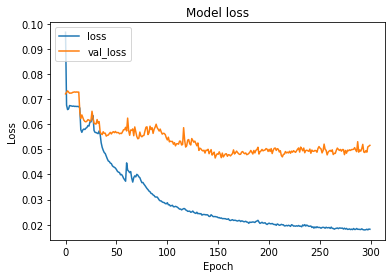

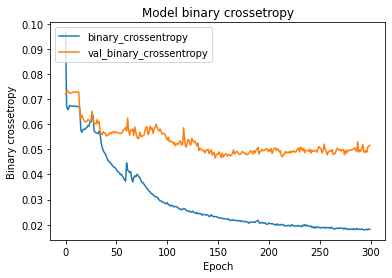

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

plt.plot(history.history['binary_crossentropy'])
plt.plot(history.history['val_binary_crossentropy'])
plt.title('Model binary crossetropy')
plt.ylabel('Binary crossetropy')
plt.xlabel('Epoch')
plt.legend(['binary_crossentropy', 'val_binary_crossentropy'], loc='upper left')

plt.show()

In [16]:
test2_list = []
test_out = []
raw_notes = test.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    test2_list.append(raw_notes[input_start:input_end])
    test_out.append(raw_notes[output_start:output_end])

test_out = list(np.array(test_out).reshape(-1, np.array(test_out).shape[-1]))

test2_list = np.array(test2_list)
test_out = np.array(test_out)

In [17]:
# predict new notes
prediction = model.predict(test2_list, verbose=0)
# round prediction to 1 or 0
prediction = np.around(prediction)
# retype it to int
prediction = prediction.astype(int)

In [18]:
np.unique(prediction)

array([0, 1])

In [19]:
bpm = 160
file_name = "./output/slipknot_final.mid"
create_midi(bpm, prediction, mid.ticks_per_beat, file_name, instruments)
# create_midi(bpm, transcription.values, mid.ticks_per_beat, "./output/transcription.mid", instruments)

In [20]:
def bleu_metric_complete_lines(candidate, reference):
    correct_lines = 0
    for i,c in enumerate(candidate):
        # line of candidate is the same as reference
        if (c == reference[i]).all() == True:
            correct_lines += 1
    
    # probability of correct lines
    return correct_lines/len(reference)

def bleu_metric_ngrams(candidate, reference, ngram):
    correct_ngrams = 0
    offset = 0
    true_flag = True
    
    for i,c in enumerate(candidate):
        
#         print(candidate[i+offset], reference[i+offset], (candidate[i+offset] == reference[i+offset]).all())
        # line is correct
        if (candidate[i] == reference[i]).all() == True:
            pass
        else:
            true_flag = False

        # every ngram sequence
        if (i+1)%ngram == 0:
#             print(i, true_flag)
            # all sequence is correct
            if true_flag:
                correct_ngrams += 1
            true_flag = True
    
    allngrams = len(reference)/ngram
#     print(correct_ngrams, allngrams)
    # probability of correct lines
    return correct_ngrams/allngrams

def bleu_metric_single_notes(candidate, reference, length_of_line):
    correct_lines = 0
    probabilities = []
    for i,c in enumerate(candidate):
        # how many notes are correct in single line
        tmp = ((c == reference[i]) == True).sum()
        # probability of correct notes in single line
        probabilities.append(tmp/length_of_line)
    
    # geometric mean of probabilities
    return gmean(probabilities)

In [21]:
candidate = prediction.copy()
reference = test_list.copy()

In [22]:
bleu_metric_complete_lines(candidate, reference)

0.2879940893978574

In [23]:
bleu_metric_single_notes(candidate, reference, length_of_line=len(instruments))

31.337106593270036

In [24]:
bleu_metric_ngrams(candidate, reference, 16)

0.28016254155892134

In [25]:
end = time.time()
print(end - start)

9488.115195989609
